### Table of Contents

* Prepare the data for ICA analysis
    * [Set working paths](#prepare_1)
    * [Pre-process the data](#prepare_2)
* Perform stabilised ICA analysis
    * [Set ICA parameters](#ica_1)
    * [Launch the stabilised ICA analysis](#ica_2)
* Create a hierarchical ICA graph
    * [Construct the full hierarchical ICA graph](#graph_1)
    * [Clean the hierarchical ICA graph](#graph_2)
* Analyse the hierarchical ICA graph
    * [Create an interactive version of the cleaned hierarchical ICA graph](#analysis_1)
    * [Extract averaged persistent components](#analysis_2)

Required packages:
- scipy == 1.4.1
- scanpy == 1.4.5.post2
- pandas == 0.24.2
- numpy == 1.16.3
- networkx == 2.3
- matplotlib == 3.0.3
- jupyterthemes == 0.20.0 (optional)
- ipywidgets == 7.4.2
- sica (https://github.com/ncaptier/Stabilized_ICA)
- hica (github URL to add)

Set working paths for the workflow <a class="anchor" id="prepare_1"></a>

In [ ]:
# Set paths and job name
### Warning: necessary parameters for graph constructions procedures! ###
Data_folder = "data"
Filename = "BRCATCGA.txt"
Job_name = "BRCATCGA"

Pre-process the data to prepare for the ICA analysis <a class="anchor" id="prepare_2"></a>

In [ ]:
# Import pre-processing functions
%run hica/preprocess_data.py

In [ ]:
# Load data from file
Data = Load_data(Data_folder, Filename, delim=",")
print(Data.shape)
# Process the data by setting to Log and removing less variable genes
Data_proc = Preprocess_data(Data, To_Log=True, Center=True, Remove_Duplicates=True)
print(Data_proc.shape)
# Save the processed data and generate a file containing only genes
Save_data(Data_proc,Data_folder,Job_name)

Set ICA parameters <a class="anchor" id="ica_1"></a>

In [ ]:
# Parameters for sICA
### Warning: necessary parameters for graph constructions procedures! ###
Minimum_decomposition = 2 # minimum decomposition order (185)
Maximum_decomposition = 100 # maximum decomposition order
Iteration_max = 1000 # maximum number of iteration until convergence of ICA
Run_number = 100 # number of reruns for stability calculation

Perform stabilised ICA using the stabilised ICA package (https://github.com/ncaptier/Stabilized_ICA) <a class="anchor" id="ica_2"></a>

In [ ]:
# Import stabilised ICA package
from sica.base import StabilizedICA as sICA
import os
import time

In [ ]:
X = Load_as_numpy(Data_folder, Job_name) #sICA accept inputs in numpy format

# Create a folder to store decomposition results
if not os.path.exists(Job_name+'_deconvolutions'):
    os.makedirs(Job_name+'_deconvolutions')

# Perform stabilised ICA runs and save S matrices (Genes vs ICA scores)
start_full = time.time()
for comp in range(Minimum_decomposition, Maximum_decomposition+1):
    print("Performing stabilised ICA for",comp,"components...")
    decomp = sICA(n_components = comp , max_iter = Iteration_max , n_jobs = -1)

    start = time.time()
    decomp.fit(X , n_runs = Run_number)
    S_ica = decomp.S_
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(str(comp) + "ICs done!" , "running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))
    np.save(file=Job_name+'_deconvolutions/'+Job_name+'_S_matrix_C'+str(comp),arr=S_ica.transpose())
end_full = time.time()
minutes, seconds = divmod(end_full - start_full, 60)
print("All ICs done!!!" , " total running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

Construct the full hierarchical ICA graph with all component Person correlations and save it in a file <a class="anchor" id="graph_1"></a>

In [ ]:
# Import graph creation related functions
%run hica/hierarchical_tree.py

In [ ]:
# Calculate all correlations between components as well as their correlation with Biton metagenes (Biton et al. Cell Rep. 2014)
Biton_folder = "data/Biton_metagenes"
Create_full_graph(Data_folder, Biton_folder, Job_name, Minimum_decomposition, Maximum_decomposition)

Construct a cleaned hierchical ICA graph following the algorithm below: <a class="anchor" id="graph_2"></a>
- Step 1: Trim the whole correlation graph by applying a Mutual Nearest Neighboor (MNN) method.
- Step 2: Delete every splits (i.e. forks between 2 components).
- Step 3: Remove components that are not found consistently over a certain threshold of decompositions, thus keeping only the peristent component segments.
- Step 4: Simplify persistent component segments by keeping only their start and end components (for the sake of visualisation clarity).
- Step 5: Reconstruct splits between persistent component segments (reconstruct the evolution of components fate through the decomposition orders).
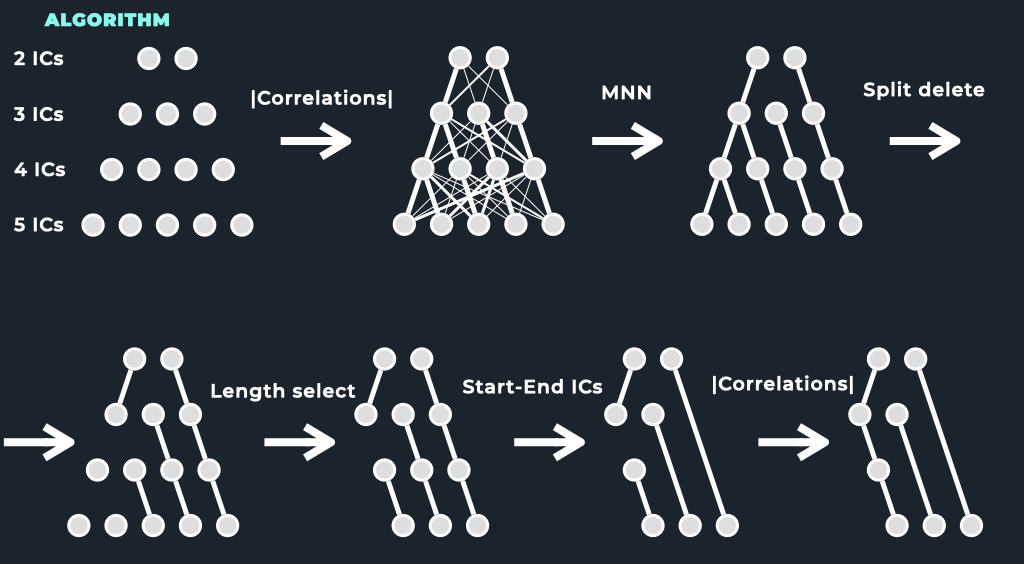

In [ ]:
# Load the graph and store it in dictionaries
Cor_dict,Sign_dict,Cor_rev_dict = Load_complete_graph(Data_folder, Biton_folder, Job_name,
                                                      Minimum_decomposition, Maximum_decomposition)
### Step 1: Perform the MMN filtering step
Gap = 1.5 # Maximal gap difference between splits
K = 2 # Maximum number of edges to accept as splits
Correlation_threshold = 0.3 # Minimal correlation between components
# Filter the complete graph by keeping only certain edges using MMN
MNN_corr_dict, MNN_sign_dict = Perform_MNN(Job_name, Minimum_decomposition, Maximum_decomposition,
                                           Gap, K, Correlation_threshold, Cor_dict, Sign_dict, Cor_rev_dict)
# Convert MMN graph from dictionary to a NetworkX graph
MNN_nx = Convert_MMN_dict_to_NetworkX(MNN_corr_dict)

### Step 2: Remove splits from graph
MMN_nosplit_nx = Delete_splits(MNN_nx)

### Step 3: Remove component under a certain length to keep only persistent components
Length_decomposition_threshold = 10 # Minimal length to be accepted as a persistent component
MMN_nosplit_persistent_nx = Clean_non_persistent_components(MMN_nosplit_nx)

### Step 4: Simply persistent components by their start and end nodes
MMN_nosplit_persistent_simple_nx, Start_end_nodes_dict = Simplify_persistent_components(MMN_nosplit_persistent_nx, Sign_dict, Job_name)

### Step 5: Reconstruct splits between persistent components and save it in a file
Correlation_threshold = 0.3 # Minimal correlation between components
Gap = 1.5 # Maximal gap difference between splits
K = 2 # Maximum number of edges to accept as splits. Set to 0 to accept all
MNN_cleaned_graph_nx, Added_edges_list = Recontruct_splits(MMN_nosplit_persistent_simple_nx, Job_name,
                                                           Sign_dict, Start_end_nodes_dict,
                                                           Correlation_threshold, Gap, K)

Create an interactive version of the hierchical ICA graph. Dashed edges represent reconstructed splits and Plain vertical edges represent persistent components.
The user has access to the following parameters to play with: <a class="anchor" id="analysis_1"></a>
- `layout`: layout of the graph
- `threshold_sign`: correlation threshold for Biton signatures and related components
- `signature`: Biton signature correlation to select related components
- `edge_select`: type of information for edges, either correlations with the selected Biton signature or Pearson correlations between starting and ending components of persistent component segments 
- `print_node_labels`: show or hide component names
- `print_edge_labels`: show or hide edge values at the center of edges
- `print_all_nodes`: show all components related to selected ones (i.e. propagate the selection through the graph) or only show the selected ones
- `source_node`: select a particular component by name and override other selections
- `genes_test`: query particular genes and select components containing those genes above a certain standard deviation threshold in `SD`.
- `SD`: set the standard deviation threshold to check for genes of interest in components
- `genes_prop`: set the minimal gene proportion to find in a component based on the quantity of genes diven in `genes_test`
- `file_name`: name of the graph picture saved in SVG format

In [ ]:
# Import packaged to create an interactive graph
%run hica/tree_analysis.py
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
### Package recommended for prettier plots ###
from jupyterthemes import jtplot
#jtplot.style("chesterish")
jtplot.style("grade3")

plt.rcParams["figure.figsize"] = (20,20)

In [ ]:
interact_manual(Create_plot_colors,
                graph=fixed(MNN_cleaned_graph_nx),
                foldername=fixed(Data_folder),
                job=fixed(Job_name),
                added_edges=fixed(Added_edges_list),
                start_nodes=fixed(Start_end_nodes_dict),
                node_cmap="Blues",
                edge_cmap="Blues",
                layout=["Alternating","Climbing"],
                threshold_sign='0.3',
                signature=["Biton_M2_GC_CONTENT",
                          "Biton_M3_SMOOTH_MUSCLE",
                          "Biton_M4_MITOCHONRIA_TRANSLATION",
                          "Biton_M5_INTERFERON",
                          "Biton_M6_BASALLIKE",
                          "Biton_M7_CELLCYCLE",
                          "Biton_M8_IMMUNE",
                          "Biton_M9_UROTHELIALDIFF",
                          "Biton_M12_MYOFIBROBLASTS",
                          "Biton_M13_BLCAPATHWAYS",
                          "Biton_M14_STRESS"],
                edge_select=["Signature_correlation","Pearson_correlation"],
                print_node_labels=False,
                print_edge_labels=False,
                print_all_nodes=True,
                source_node="",
                genes_test="",
                SD="3",
                genes_prop="0.1",
                file_name='Graphs/'+Job_name
                );

Extract persistent components averaged over a certain score:<a class="anchor" id="analysis_2"></a>
- `icascore`: simple average of scores given by the ICA. Use the `Threshold` parameter to select the number of top contributing genes to use for the positive heavy tail orientation
- `zscore`: average over Z-scores. Use the `Threshold` parameter to select the Standard Variation threshold for the positive heavy tail orientation.
- `rank`: average over Z-scores then convert them to ordered ranked positions in the component (highest Z-score has a rank position of 1). Use the `Threshold` parameter to select the Standard Variation threshold for the positive heavy tail orientation.

In [ ]:
# Parameters for averaging persistent components
Score_type = "rank" # Use zscore, icascore or rank
Threshold = 3
Compute_average_segments(MMN_nosplit_persistent_nx, MMN_nosplit_persistent_simple_nx, Score_type, Threshold, Data_folder, Job_name)